# Predicting House Prices In Bengaluru

## Overview
What are the things that a potential home buyer considers before purchasing a house? The location, the size of the property, vicinity to offices, schools, parks, restaurants, hospitals or the stereotypical white picket fence? What about the most important factor -- the price? Now with the lingering impact of demonetization, the enforcement of the Real Estate (Regulation and Development) Act (RERA), and the lack of trust in property developers in the city, housing units sold across India in 2017 dropped by 7 percent. In fact, the property prices in Bengaluru fell by almost 5 percent in the second half of 2017, said a study published by property consultancy Knight Frank. For example, for a potential homeowner, over 9,000 apartment projects and flats for sale are available in the range of ₹42-52 lakh, followed by over 7,100 apartments that are in the ₹52-62 lakh budget segment, says a report by property website Makaan. According to the study, there are over 5,000 projects in the ₹15-25 lakh budget segment followed by those in the ₹34-43 lakh budget category. Buying a home, especially in a city like Bengaluru, is a tricky choice. While the major factors are usually the same for all metros, there are others to be considered for the Silicon Valley of India. With its help millennial crowd, vibrant culture, great climate and a slew of job opportunities, it is difficult to ascertain the price of a house in Bengaluru.   So what determines the property prices in Namma Bengaluru?

##### Data 

The train and test data will consist of various features that describe that property in Bengaluru. This is an actual data set that is curated over months of primary & secondary research by our team. Each row contains fixed size object of features. There are 9 features and each feature can be accessed by its name. 
- Features Area_type - describes the area 
- Availability - when it can be possessed or when it is ready(categorical and time-series) 
- Location - where it is located in Bengaluru 
- Price - Value of the property in lakhs(INR) 
- Size - in BHK or Bedroom (1-10 or more)
- Society - to which society it belongs
- Total_sqft - size of the property in sq.ft
- Bath - No. of bathrooms 
- Balcony - No. of the balcony 

##### Problem Statement 

With the given 9 features(categorical and continuous) build a model to predict the price of houses in Bengaluru.


## Evaluation
```python
1 - np.sqrt(np.square(np.log10(y_pred +1) - np.log10(y_true +1)).mean())
```

## Imports

In [164]:
import pandas as pd
import seaborn as sns
from IPython.core.interactiveshell import InteractiveShell
import matplotlib.pyplot as plt
InteractiveShell.ast_node_interactivity = "all"
from IPython.core.pylabtools import figsize
import numpy as np
import pickle
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score, log_loss
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

from hyperopt import hp,fmin,Trials,tpe,SparkTrials
import xgboost as xgb
from scipy.stats import uniform, randint
from scipy import stats
from sklearn import tree
from sklearn.metrics import mean_squared_error
import string
import re
from catboost import CatBoost, CatBoostRegressor, Pool
from sklearn.preprocessing import PowerTransformer

In [155]:
train=pd.read_csv("./Data/Train.csv")
test=pd.read_csv("./Data/Test.csv")
seed=42

In [3]:
train_orig=train.copy()
test_orig=test.copy()

In [103]:
def value_counts_df(df, col):
    """
    Returns pd.value_counts() as a DataFrame

    Parameters
    ----------
    df : Pandas Dataframe
        Dataframe on which to run value_counts(), must have column `col`.
    col : str
        Name of column in `df` for which to generate counts

    Returns
    -------
    Pandas Dataframe
        Returned dataframe will have a single column named "count" which contains the count_values()
        for each unique value of df[col]. The index name of this dataframe is `col`.

    Example
    -------
    >>> value_counts_df(pd.DataFrame({'a':[1, 1, 2, 2, 2]}), 'a')
       count
    a
    2      3
    1      2
    """
    df = pd.DataFrame(df[col].value_counts())
    df.index.name = col
    df.columns = ['count']
    return df

def cleanLocationSociety(data):
    if (type(data) != str):
        data=str(data)
    data=data.translate(str.maketrans('', '', string.punctuation))
    data=' '.join(data.split())
    data=data.lower()
    arr=data.split(" ")
    return data

def clean_availabilty(data):
    pattern = '^\d'
    result = re.match(pattern, data)
    if result:
        return "Not Available"
    else:
        return data
    
def show_missing_count(data):
    miss_percent = (data.isnull().sum() / len(data)) * 100
    missing = pd.DataFrame({"Percent":miss_percent, 'Count':data.isnull().sum()}).sort_values(by="Percent", ascending=False)
    missing=missing.loc[missing['Percent'] > 0]
    return missing
    

## Data Cleaning

In [8]:
train.head(10)
test.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00
5,Super built-up Area,Ready To Move,Whitefield,2 BHK,DuenaTa,1170,2.0,1.0,38.00
6,Super built-up Area,18-May,Old Airport Road,4 BHK,Jaades,2732,4.0,NaN,204.00
7,Super built-up Area,Ready To Move,Rajaji Nagar,4 BHK,Brway G,3300,4.0,NaN,600.00
8,Super built-up Area,Ready To Move,Marathahalli,3 BHK,NaN,1310,3.0,1.0,63.25
9,Plot Area,Ready To Move,Gandhi Bazar,6 Bedroom,NaN,1020,6.0,NaN,370.00


,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,Ready To Move,Brookefield,2 BHK,Roeekbl,1225,2.0,2.0,NaN
1,Plot Area,Ready To Move,Akshaya Nagar,9 Bedroom,NaN,2400,9.0,2.0,NaN
2,Plot Area,18-Apr,Hennur Road,4 Bedroom,Saandtt,1650,5.0,2.0,NaN
3,Super built-up Area,Ready To Move,Kodichikkanahalli,3 BHK,Winerri,1322,3.0,1.0,NaN
4,Super built-up Area,Ready To Move,Konanakunte,2 BHK,AmageSa,1161,2.0,1.0,NaN


In [59]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
 9   source        13320 non-null  object 
dtypes: float64(3), object(7)
memory usage: 1.0+ MB


In [10]:
show_missing_count(train)
show_missing_count(test)

,Percent,Count
society,41.306306,5502
balcony,4.572072,609
bath,0.548048,73
size,0.120120,16
location,0.007508,1


,Percent,Count
price,100.000000,1480
society,42.297297,626
balcony,4.662162,69
bath,0.472973,7
size,0.135135,2


In [40]:
train.describe()

,bath,balcony,price
count,13247.000000,12711.000000,13320.000000
mean,2.692610,1.584376,112.565627
std,1.341458,0.817263,148.971674
min,1.000000,0.000000,8.000000
25%,2.000000,1.000000,50.000000
50%,2.000000,2.000000,72.000000
75%,3.000000,2.000000,120.000000
max,40.000000,3.000000,3600.000000


In [ ]:
# def prepare_data(data):

#### Concat data to clean data on both sets

In [109]:
train["source"]="train"
test["source"]="test"
fulldata=pd.concat([train,test]).reset_index()
fulldata.head()
fulldata.sample(5)

,index,area_type,availability,location,size,society,total_sqft,bath,balcony,price,source
0,0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07,train
1,1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00,train
2,2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00,train
3,3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00,train
4,4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00,train


,index,area_type,availability,location,size,society,total_sqft,bath,balcony,price,source
6582,6582,Built-up Area,Ready To Move,7th Phase JP Nagar,2 BHK,NaN,1000,2.0,1.0,61.0,train
13547,227,Super built-up Area,Ready To Move,Gottigere,3 BHK,KSicaxo,1500,3.0,2.0,NaN,test
10702,10702,Super built-up Area,Ready To Move,Sarjapur,2 BHK,NaN,1150,2.0,1.0,41.0,train
3251,3251,Super built-up Area,Ready To Move,Harlur,3 BHK,Prncyrn,1749,3.0,2.0,115.0,train
654,654,Super built-up Area,20-Oct,Kanakpura Road,3 BHK,PrarePa,1100,2.0,1.0,58.0,train


In [150]:
fulldata.sample(5)

,index,area_type,availability,location,size,society,total_sqft,bath,balcony,price,source,belongs_to_society,total_area
4997,4997,Super built-up Area,Ready To Move,raja rajeshwari nagar,2.0,no_society,1095,2.0,1.0,38.33,train,0,1095
8825,8825,Built-up Area,Ready To Move,sector 1 hsr layout,3.0,no_society,1720,3.0,3.0,83.00,train,0,1720
13534,214,Plot Area,Ready To Move,rt nagar,7.0,no_society,2400,8.0,NaN,NaN,test,0,2400
7700,7700,Plot Area,Ready To Move,nagawara junction,3.0,no_society,1200,3.0,2.0,200.00,train,0,1200
7016,7016,Plot Area,Ready To Move,kengeri,2.0,no_society,1200,2.0,0.0,58.00,train,0,1200


In [110]:
fulldata["size"]=fulldata["size"].apply(lambda x:x.split(" ")[0] if pd.notnull(x) else x) 

In [111]:
fulldata["size"] =pd.to_numeric(fulldata["size"])

In [112]:
fulldata["location"].value_counts()

Whitefield                                591
Sarjapur  Road                            437
Electronic City                           337
Kanakpura Road                            298
Thanisandra                               277
                                         ... 
Shettihalli                                 1
Banashankari 6th Stage ,Subramanyapura      1
nynappanahalli                              1
KAS Officers Colony                         1
Abshot Layout                               1
Name: location, Length: 1358, dtype: int64

#### Clean location

In [113]:
%%time
fulldata["location"] = fulldata["location"].apply(lambda x:cleanLocationSociety(x))

Wall time: 59 ms


In [114]:
fulldata["location"].value_counts()

whitefield               594
sarjapur road            448
electronic city          339
kanakpura road           299
thanisandra              280
                        ... 
vinayakanagar              1
mg road                    1
sri kanteshwara nagar      1
bapuji layout              1
sipcot 1                   1
Name: location, Length: 1319, dtype: int64

In [115]:
# fulldata.drop("index",axis=1,inplace=True)

In [116]:
pickle.dump(fulldata,open('fulldata.pk', 'wb'))

In [65]:
with open('fulldata.pk','rb') as f:
    fulldata = pickle.load(f)

In [117]:
fulldata["area_type"].value_counts()

Super built-up  Area    9736
Built-up  Area          2688
Plot  Area              2279
Carpet  Area              97
Name: area_type, dtype: int64

In [118]:
fulldata["society"].value_counts()

GrrvaGr    92
PrarePa    78
Prtates    64
Bhmesy     63
Sryalan    63
           ..
Gentson     1
Fleepi      1
NianaKe     1
Saeraep     1
S onsMa     1
Name: society, Length: 2832, dtype: int64

#### Clean Society

In [119]:
%%time
fulldata["society"] = fulldata["society"].apply(lambda x:cleanLocationSociety(x) if pd.notnull(x) else x )

Wall time: 45 ms


In [120]:
fulldata["society"].isnull().value_counts()

False    8672
True     6128
Name: society, dtype: int64

In [121]:
fulldata["society"].value_counts()

grrvagr    92
prarepa    78
prtates    64
sryalan    63
bhmesy     63
           ..
jainaht     1
vancya      1
srncykh     1
srntssh     1
brsic c     1
Name: society, Length: 2829, dtype: int64

In [122]:
fulldata["belongs_to_society"] = fulldata["society"].notnull().astype(int)

In [123]:
fulldata["belongs_to_society"]

0        1
1        1
2        0
3        1
4        0
        ..
14795    1
14796    0
14797    1
14798    1
14799    1
Name: belongs_to_society, Length: 14800, dtype: int32

In [124]:
fulldata["society"].fillna('no_society',inplace=True)

In [125]:
fulldata["society"]

0            coomee
1           theanmp
2        no_society
3           soiewre
4        no_society
            ...    
14795       prlla c
14796    no_society
14797       unm 2el
14798       sahtsva
14799       maicars
Name: society, Length: 14800, dtype: object

In [129]:
fulldata.head()
fulldata.sample(5)

,index,area_type,availability,location,size,society,total_sqft,bath,balcony,price,source,belongs_to_society
0,0,Super built-up Area,19-Dec,electronic city phase ii,2.0,coomee,1056,2.0,1.0,39.07,train,1
1,1,Plot Area,Ready To Move,chikka tirupathi,4.0,theanmp,2600,5.0,3.0,120.00,train,1
2,2,Built-up Area,Ready To Move,uttarahalli,3.0,no_society,1440,2.0,3.0,62.00,train,0
3,3,Super built-up Area,Ready To Move,lingadheeranahalli,3.0,soiewre,1521,3.0,1.0,95.00,train,1
4,4,Super built-up Area,Ready To Move,kothanur,2.0,no_society,1200,2.0,1.0,51.00,train,0


,index,area_type,availability,location,size,society,total_sqft,bath,balcony,price,source,belongs_to_society
8090,8090,Super built-up Area,Ready To Move,channasandra,2.0,unm 2el,1093,2.0,1.0,34.0,train,1
10885,10885,Plot Area,Ready To Move,cooke town,3.0,no_society,2600,3.0,1.0,375.0,train,0
14071,751,Super built-up Area,18-Mar,jakkur,3.0,lecco c,4150,5.0,1.0,NaN,test,1
7320,7320,Plot Area,Ready To Move,2nd phase jp nagar jp nagar,3.0,no_society,1200,3.0,1.0,205.0,train,0
624,624,Super built-up Area,Ready To Move,tumkur road,3.0,sosonga,1500,3.0,3.0,95.0,train,1


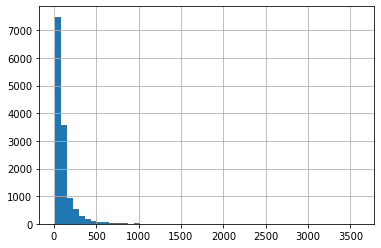

In [130]:
fulldata["price"].hist(bins=50)

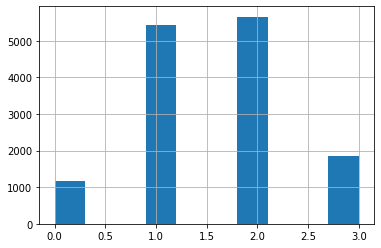

In [131]:
fulldata["balcony"].hist()

In [132]:
fulldata["bath"].value_counts()

2.0     7652
3.0     3657
4.0     1375
1.0      871
5.0      586
6.0      303
7.0      113
8.0       73
9.0       52
10.0      17
12.0       7
13.0       3
11.0       3
16.0       3
27.0       1
18.0       1
40.0       1
15.0       1
14.0       1
Name: bath, dtype: int64

In [133]:
fulldata.loc[fulldata["bath"]==40]

,index,area_type,availability,location,size,society,total_sqft,bath,balcony,price,source,belongs_to_society
4684,4684,Plot Area,Ready To Move,munnekollal,43.0,no_society,2400,40.0,0.0,660.0,train,0


In [134]:
fulldata["availability"].value_counts()

Ready To Move    11743
18-Dec             351
18-May             324
18-Apr             296
18-Aug             225
                 ...  
15-Dec               1
15-Jun               1
16-Apr               1
14-Jul               1
16-Jan               1
Name: availability, Length: 82, dtype: int64

In [135]:
availability=value_counts_df(fulldata,"availability")

In [57]:
availability.loc[availability["count"]>10]

,count
availability,
Ready To Move,11743
18-Dec,351
18-May,324
18-Apr,296
18-Aug,225
19-Dec,218
18-Jul,160
18-Mar,147
20-Dec,109


In [136]:
fulldata["availability"]=fulldata["availability"].apply(lambda x: clean_availabilty(x))

In [137]:
fulldata["availability"]

0        Not Available
1        Ready To Move
2        Ready To Move
3        Ready To Move
4        Ready To Move
             ...      
14795    Ready To Move
14796    Ready To Move
14797    Ready To Move
14798    Not Available
14799    Ready To Move
Name: availability, Length: 14800, dtype: object

#### Cleaning Area(total_sqft)

In [85]:
"454.33".replace('.', '', 1).isdigit() 

True

In [86]:
def initialAreaCleanup(data):
    if(data.replace('.', '', 1).isdigit()):
        return pd.to_numeric(data)
    elif ('-' in data):
        arr=data.split("-")
        arr=[pd.to_numeric(x) for x in arr]
        avg=np.mean(arr)
        return avg
    else:return data
    


initialAreaCleanup("454.33")

454.33

In [212]:
total_sqft_inital=fulldata["total_sqft"].apply(lambda x: initialAreaCleanup(x) )

In [213]:
total_sqft_inital.sample(10)

8310     1200
5632     1200
1673     1306
8501     1125
11074     860
14520    1700
7555     1458
7540     1350
12573    1195
12594    1200
Name: total_sqft, dtype: object

In [215]:
fulldata.iloc[7555]

index                                 7555
area_type             Super built-up  Area
availability                 Ready To Move
location                        whitefield
size                                     3
society                            bmttaor
total_sqft                            1458
bath                                     2
balcony                                  2
price                                   62
source                               train
belongs_to_society                       1
total_area                            1458
Name: 7555, dtype: object

In [141]:
only_string_area = total_sqft_inital[total_sqft_inital.apply(lambda x: isinstance(x, str))]

In [194]:
only_string_area

410       34.46Sq. Meter
648            4125Perch
775        1000Sq. Meter
872        1100Sq. Yards
1019           5.31Acres
1086             30Acres
1400        716Sq. Meter
1712       1500Sq. Meter
1743     142.61Sq. Meter
1821       1574Sq. Yards
2310     361.33Sq. Yards
2881        117Sq. Yards
3228       3040Sq. Meter
3285        500Sq. Yards
4113        167Sq. Meter
4293        315Sq. Yards
5453              3Cents
5537     188.89Sq. Yards
5631        204Sq. Meter
5668         45Sq. Yards
5708      133.3Sq. Yards
5976      78.03Sq. Meter
6268        122Sq. Yards
6303      84.53Sq. Meter
6333           2.09Acres
6552            24Guntha
6592        697Sq. Meter
6953     142.61Sq. Meter
7001           1500Cents
7248        132Sq. Yards
7334              2Acres
7520       1100Sq. Meter
7607             15Acres
7726           1.26Acres
8273     151.11Sq. Yards
9423            1Grounds
9519       2940Sq. Yards
9734      45.06Sq. Meter
10488          1.25Acres
10491     86.72Sq. Meter


In [143]:
def extract_units(data):
#     return re.findall('\d*\.?\d+', data)
    data=data.replace(" ", "")
    return re.findall('[a-zA-Z]*\.?[a-zA-Z]+', data)

def extract_number(data):
    return re.findall('\d*\.?\d+', data)


def covertToSqFeet(data):
    unit=extract_units(data)[0]
    value=pd.to_numeric(extract_number(data)[0])
    if(unit=="Sq.Meter"):
        return 10.764*value
    elif(unit=="Guntha"):
        return 1088.98*value
    elif(unit=="Acres"):
        return 43559.99*value
    elif(unit=="Sq.Yards"):
        return 9*value
    elif(unit=="Cents"):
        return 435.6*value
    elif(unit=="Perch"):
        return 272.25*value
    elif(unit=="Grounds"):
        return 2400*value


covertToSqFeet("1Grounds")

2400

In [184]:
only_string_converted=only_string_area.apply(lambda x:covertToSqFeet(x))

In [192]:
only_string_converted

410      3.709274e+02
648      1.123031e+06
775      1.076400e+04
872      9.900000e+03
1019     2.313035e+05
1086     1.306800e+06
1400     7.707024e+03
1712     1.614600e+04
1743     1.535054e+03
1821     1.416600e+04
2310     3.251970e+03
2881     1.053000e+03
3228     3.272256e+04
3285     4.500000e+03
4113     1.797588e+03
4293     2.835000e+03
5453     1.306800e+03
5537     1.700010e+03
5631     2.195856e+03
5668     4.050000e+02
5708     1.199700e+03
5976     8.399149e+02
6268     1.098000e+03
6303     9.098809e+02
6333     9.104038e+04
6552     2.613552e+04
6592     7.502508e+03
6953     1.535054e+03
7001     6.534000e+05
7248     1.188000e+03
7334     8.711998e+04
7520     1.184040e+04
7607     6.533998e+05
7726     5.488559e+04
8273     1.359990e+03
9423     2.400000e+03
9519     2.646000e+04
9734     4.850258e+02
10488    5.444999e+04
10491    9.334541e+02
11320    4.138124e+04
11615    2.613599e+05
12186    1.080000e+03
12252    2.583360e+02
12560    1.537530e+03
12652    2

In [216]:
a=total_sqft_inital.to_frame()
b=only_string_converted.to_frame()

In [217]:
a.info()
b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14800 entries, 0 to 14799
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   total_sqft  14800 non-null  object
dtypes: object(1)
memory usage: 115.8+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 48 entries, 410 to 14194
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   total_sqft  48 non-null     float64
dtypes: float64(1)
memory usage: 2.0 KB


In [218]:
a.update(b)

In [220]:
a.iloc[410]

total_sqft    370.927
Name: 410, dtype: object

In [221]:
fulldata["total_area"]=a["total_sqft"]

In [222]:
fulldata["total_area"][410]

370.92744

In [223]:
fulldata["total_area"]=pd.to_numeric(fulldata["total_area"])

In [226]:
fulldata.sample(10)

,index,area_type,availability,location,size,society,total_sqft,bath,balcony,price,source,belongs_to_society,total_area
1102,1102,Super built-up Area,Not Available,hennur road,3.0,orens g,1561,3.0,2.0,95.00,train,1,1561.0
9214,9214,Super built-up Area,Ready To Move,whitefield,3.0,gotis a,1720,3.0,3.0,98.97,train,1,1720.0
2167,2167,Built-up Area,Ready To Move,nelamangala,2.0,no_society,1095,2.0,0.0,40.00,train,0,1095.0
14445,1125,Plot Area,Not Available,ardendale,4.0,no_society,2000,4.0,1.0,NaN,test,0,2000.0
6253,6253,Super built-up Area,Ready To Move,nagarbhavi,3.0,no_society,1850,2.0,2.0,89.00,train,0,1850.0
11668,11668,Plot Area,Ready To Move,bapuji nagar,4.0,no_society,1125,3.0,2.0,126.00,train,0,1125.0
9756,9756,Super built-up Area,Ready To Move,haralur road,3.0,no_society,1710,3.0,2.0,85.00,train,0,1710.0
14125,805,Built-up Area,Ready To Move,bisuvanahalli,3.0,prityel,1075,3.0,2.0,NaN,test,1,1075.0
681,681,Plot Area,Ready To Move,ombr layout,4.0,no_society,2400,4.0,2.0,375.00,train,0,2400.0
7203,7203,Super built-up Area,Ready To Move,sarjapura main road,4.0,no_society,2400,4.0,3.0,250.00,train,0,2400.0


In [227]:
fulldata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14800 entries, 0 to 14799
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index               14800 non-null  int64  
 1   area_type           14800 non-null  object 
 2   availability        14800 non-null  object 
 3   location            14800 non-null  object 
 4   size                14782 non-null  float64
 5   society             14800 non-null  object 
 6   total_sqft          14800 non-null  object 
 7   bath                14720 non-null  float64
 8   balcony             14122 non-null  float64
 9   price               13320 non-null  float64
 10  source              14800 non-null  object 
 11  belongs_to_society  14800 non-null  int32  
 12  total_area          14800 non-null  float64
dtypes: float64(5), int32(1), int64(1), object(6)
memory usage: 1.4+ MB


In [228]:
pickle.dump(fulldata,open('fulldata_2.pk', 'wb'))

In [8]:
with open('fulldata_2.pk','rb') as f:
    fulldata = pickle.load(f)

In [9]:
fulldata.sample(10)

,index,area_type,availability,location,size,society,total_sqft,bath,balcony,price,source,belongs_to_society,total_area
14330,1010,Built-up Area,Ready To Move,sarjapur road,1.0,no_society,470,1.0,1.0,NaN,test,0,470.0
8969,8969,Super built-up Area,Ready To Move,bhuvaneshwari nagar,2.0,no_society,1000,2.0,2.0,60.00,train,0,1000.0
9974,9974,Plot Area,Ready To Move,sector 1 hsr layout,3.0,no_society,2400,6.0,2.0,775.00,train,0,2400.0
5336,5336,Super built-up Area,Ready To Move,kundalahalli,3.0,dieldli,1724,3.0,2.0,124.00,train,1,1724.0
1336,1336,Super built-up Area,Ready To Move,thanisandra,2.0,bhmesy,1265,2.0,2.0,85.00,train,1,1265.0
13424,104,Super built-up Area,Ready To Move,rmv extension,2.0,s alspe,1000,2.0,2.0,NaN,test,1,1000.0
225,225,Super built-up Area,Ready To Move,muthurayya swamy layout,3.0,maclek,2405,4.0,2.0,260.00,train,1,2405.0
5030,5030,Super built-up Area,Ready To Move,devarachikkanahalli,2.0,no_society,1170,2.0,2.0,40.00,train,0,1170.0
10816,10816,Super built-up Area,Ready To Move,uttarahalli,2.0,no_society,1050,2.0,1.0,42.00,train,0,1050.0
859,859,Super built-up Area,Ready To Move,talaghattapura,2.0,no_society,1090,2.0,1.0,27.24,train,0,1090.0


In [10]:
show_missing_count(fulldata)

,Percent,Count
price,10.000000,1480
balcony,4.581081,678
bath,0.540541,80
size,0.121622,18


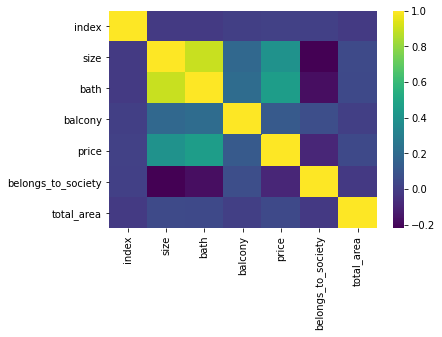

In [11]:
sns.heatmap(fulldata.corr(),cmap="viridis")

In [12]:
fulldata=pd.concat([fulldata, pd.get_dummies(fulldata["area_type"],prefix="area_type")], axis=1)

In [13]:
fulldata=pd.concat([fulldata, pd.get_dummies(fulldata["availability"],prefix="availability")], axis=1)

In [14]:
fulldata.drop("index",inplace=True,axis=1)

In [15]:
fulldata.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price,source,belongs_to_society,total_area,area_type_Built-up Area,area_type_Carpet Area,area_type_Plot Area,area_type_Super built-up Area,availability_Immediate Possession,availability_Not Available,availability_Ready To Move
0,Super built-up Area,Not Available,electronic city phase ii,2.0,coomee,1056,2.0,1.0,39.07,train,1,1056.0,0,0,0,1,0,1,0
1,Plot Area,Ready To Move,chikka tirupathi,4.0,theanmp,2600,5.0,3.0,120.00,train,1,2600.0,0,0,1,0,0,0,1
2,Built-up Area,Ready To Move,uttarahalli,3.0,no_society,1440,2.0,3.0,62.00,train,0,1440.0,1,0,0,0,0,0,1
3,Super built-up Area,Ready To Move,lingadheeranahalli,3.0,soiewre,1521,3.0,1.0,95.00,train,1,1521.0,0,0,0,1,0,0,1
4,Super built-up Area,Ready To Move,kothanur,2.0,no_society,1200,2.0,1.0,51.00,train,0,1200.0,0,0,0,1,0,0,1


In [16]:
fulldata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14800 entries, 0 to 14799
Data columns (total 19 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   area_type                          14800 non-null  object 
 1   availability                       14800 non-null  object 
 2   location                           14800 non-null  object 
 3   size                               14782 non-null  float64
 4   society                            14800 non-null  object 
 5   total_sqft                         14800 non-null  object 
 6   bath                               14720 non-null  float64
 7   balcony                            14122 non-null  float64
 8   price                              13320 non-null  float64
 9   source                             14800 non-null  object 
 10  belongs_to_society                 14800 non-null  int32  
 11  total_area                         14800 non-null  flo

In [17]:
pickle.dump(fulldata,open('fulldata_3.pk', 'wb'))

In [5]:
with open('fulldata_3.pk','rb') as f:
    fulldata = pickle.load(f)

In [59]:
train_df=fulldata.loc[fulldata["source"]=="train"]
test_df=fulldata.loc[fulldata["source"]=="test"]
train_df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price,source,belongs_to_society,total_area,area_type_Built-up Area,area_type_Carpet Area,area_type_Plot Area,area_type_Super built-up Area,availability_Immediate Possession,availability_Not Available,availability_Ready To Move
0,Super built-up Area,Not Available,electronic city phase ii,2.0,coomee,1056,2.0,1.0,39.07,train,1,1056.0,0,0,0,1,0,1,0
1,Plot Area,Ready To Move,chikka tirupathi,4.0,theanmp,2600,5.0,3.0,120.00,train,1,2600.0,0,0,1,0,0,0,1
2,Built-up Area,Ready To Move,uttarahalli,3.0,no_society,1440,2.0,3.0,62.00,train,0,1440.0,1,0,0,0,0,0,1
3,Super built-up Area,Ready To Move,lingadheeranahalli,3.0,soiewre,1521,3.0,1.0,95.00,train,1,1521.0,0,0,0,1,0,0,1
4,Super built-up Area,Ready To Move,kothanur,2.0,no_society,1200,2.0,1.0,51.00,train,0,1200.0,0,0,0,1,0,0,1


## Missing Values

In [48]:
show_missing_count(train_df)
show_missing_count(test_df)

,Percent,Count
balcony,4.572072,609
bath,0.548048,73
size,0.120120,16


,Percent,Count
price,100.000000,1480
balcony,4.662162,69
bath,0.472973,7
size,0.135135,2


In [57]:
train_df["balcony"].mode()
test_df["balcony"].mode()

0    2.0
dtype: float64

0    1.0
dtype: float64

In [60]:
train_df["balcony"].fillna(2,inplace=True)
test_df["balcony"].fillna(1,inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [65]:
train_df["bath"].describe()
test_df["bath"].describe()
train_df["bath"].mode()
test_df["bath"].mode()

count    13247.000000
mean         2.692610
std          1.341458
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         40.000000
Name: bath, dtype: float64

count    1473.000000
mean        2.753564
std         1.365218
min         1.000000
25%         2.000000
50%         2.000000
75%         3.000000
max        16.000000
Name: bath, dtype: float64

0    2.0
dtype: float64

0    2.0
dtype: float64

In [66]:
train_df["bath"].fillna(2,inplace=True)
test_df["bath"].fillna(2,inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [68]:
train_df["size"].describe()
test_df["size"].describe()
train_df["size"].mode()
test_df["size"].mode()

count    13304.000000
mean         2.803743
std          1.294974
min          1.000000
25%          2.000000
50%          3.000000
75%          3.000000
max         43.000000
Name: size, dtype: float64

count    1478.000000
mean        2.884980
std         1.355159
min         1.000000
25%         2.000000
50%         3.000000
75%         3.000000
max        16.000000
Name: size, dtype: float64

0    2.0
dtype: float64

0    2.0
dtype: float64

In [69]:
train_df["size"].fillna(2,inplace=True)
test_df["size"].fillna(2,inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [70]:
show_missing_count(train_df)
show_missing_count(test_df)

,Percent,Count


,Percent,Count
price,100.0,1480


In [71]:
pickle.dump(train_df,open('train_df.pk', 'wb'))
pickle.dump(test_df,open('test_df.pk', 'wb'))

In [17]:
with open('train_df.pk','rb') as f:
    train_df = pickle.load(f)

with open('test_df.pk','rb') as f:
    test_df = pickle.load(f)    

## EDA

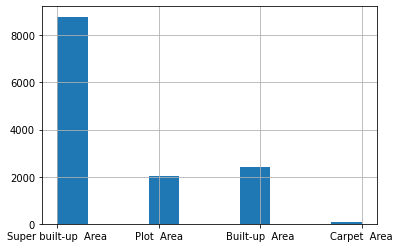

In [162]:
train_df["area_type"].hist()

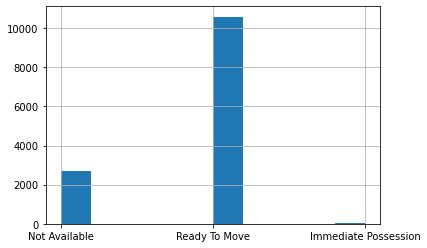

In [163]:
train_df["availability"].hist()

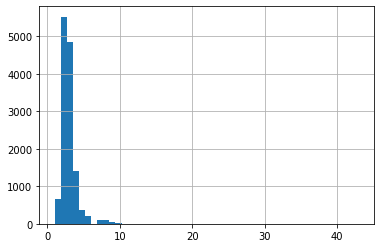

In [166]:
train_df["size"].hist(bins=50)	#bedroom count

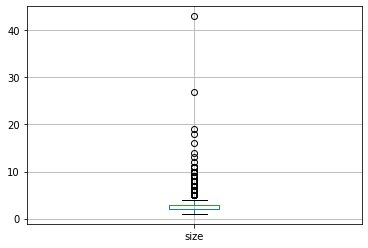

In [5]:
train_df.boxplot(column="size")

##### Drop data with high bedroom numbers

In [8]:
train_df[train_df["size"]>20]

,area_type,availability,location,size,society,total_sqft,bath,balcony,price,source,belongs_to_society,total_area,area_type_Built-up Area,area_type_Carpet Area,area_type_Plot Area,area_type_Super built-up Area,availability_Immediate Possession,availability_Not Available,availability_Ready To Move
1718,Super built-up Area,Ready To Move,2electronic city phase ii,27.0,no_society,8000,27.0,0.0,230.0,train,0,8000.0,0,0,0,1,0,0,1
4684,Plot Area,Ready To Move,munnekollal,43.0,no_society,2400,40.0,0.0,660.0,train,0,2400.0,0,0,1,0,0,0,1


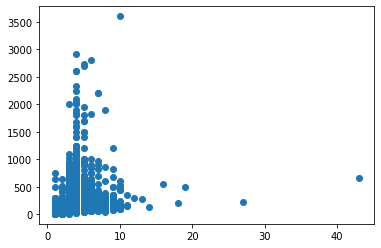

In [11]:
plt.scatter(train_df["size"],train_df["price"])

In [18]:
train_df=train_df[train_df["size"]<20]

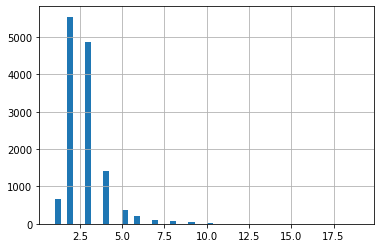

In [87]:
train_df["size"].hist(bins=50)	#bedroom count
# Check with power transform later

(array([6.550e+02, 0.000e+00, 5.543e+03, 0.000e+00, 4.855e+03, 1.417e+03,
        5.770e+02, 1.880e+02, 7.200e+01, 5.000e+00]),
 array([-2.52354907, -1.85488128, -1.18621349, -0.5175457 ,  0.15112209,
         0.81978987,  1.48845766,  2.15712545,  2.82579324,  3.49446103,
         4.16312882]),
 <a list of 10 Patch objects>)

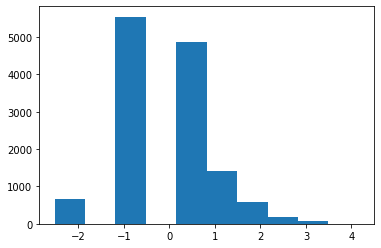

In [88]:
# pt=PowerTransformer()
# plt.hist(pt.fit_transform(train_df["size"].values.reshape(-1, 1)))

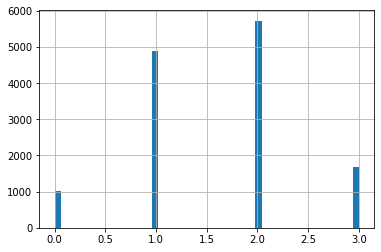

In [19]:
train_df["balcony"].hist(bins=50)

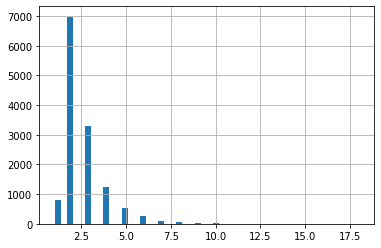

In [90]:
train_df["bath"].hist(log=False,bins=50)

##### Drop data with high area

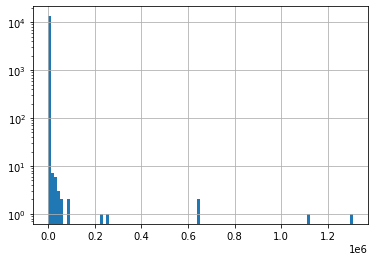

In [32]:
train_df["total_area"].hist(bins=100,log=True)

In [39]:
train_df["total_area"].sort_values()[::-1]

1086     1306799.70
648      1123031.25
7001      653400.00
7607      653399.85
11615     261359.94
            ...    
1122          24.00
1020          15.00
349           11.00
4972           5.00
4086           1.00
Name: total_area, Length: 13318, dtype: float64

In [42]:
train_df[train_df["total_area"]>100000]

,area_type,availability,location,size,society,total_sqft,bath,balcony,price,source,belongs_to_society,total_area,area_type_Built-up Area,area_type_Carpet Area,area_type_Plot Area,area_type_Super built-up Area,availability_Immediate Possession,availability_Not Available,availability_Ready To Move
648,Built-up Area,Ready To Move,arekere,9.0,no_society,4125Perch,9.0,2.0,265.0,train,0,1.123031e+06,1,0,0,0,0,0,1
1019,Plot Area,Not Available,marathi layout,1.0,no_society,5.31Acres,1.0,0.0,110.0,train,0,2.313035e+05,0,0,1,0,0,1,0
1086,Plot Area,Not Available,narasapura,2.0,no_society,30Acres,2.0,2.0,29.5,train,0,1.306800e+06,0,0,1,0,0,1,0
7001,Plot Area,Ready To Move,thyagaraja nagar,8.0,no_society,1500Cents,6.0,2.0,290.0,train,0,6.534000e+05,0,0,1,0,0,0,1
7607,Plot Area,Ready To Move,bommenahalli,3.0,prood g,15Acres,3.0,1.0,217.0,train,1,6.533998e+05,0,0,1,0,0,0,1
11615,Plot Area,Ready To Move,arudi,3.0,no_society,6Acres,2.0,0.0,80.0,train,0,2.613599e+05,0,0,1,0,0,0,1


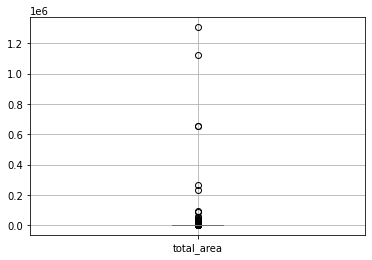

In [43]:
train_df.boxplot(column="total_area")

In [44]:
train_df=train_df[train_df["total_area"]<100000]

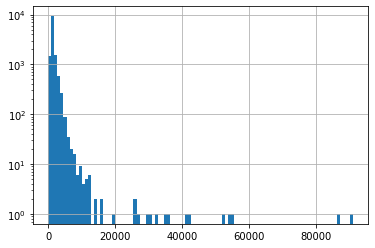

In [70]:
train_df["total_area"].hist(bins=100,log=True)

In [71]:
area_power_transformer = PowerTransformer()

In [77]:
train_df["total_area_power_transformed"] = area_power_transformer.fit_transform(train_df["total_area"].values.reshape(-1, 1))

In [79]:
test_df["total_area_power_transformed"]=area_power_transformer.transform(test_df["total_area"].values.reshape(-1, 1))

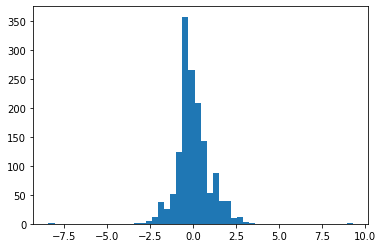

In [80]:
plt.hist(test_df["total_area_power_transformed"],bins=50);

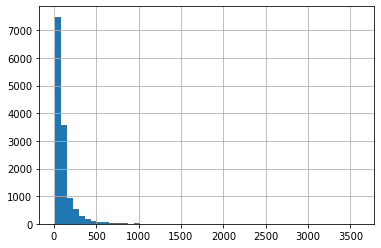

In [49]:
train_df["price"].hist(bins=50,log=False)

In [63]:
# pt=PowerTransformer()

# test_power=pt.fit_transform(X=train_df["price"].values.reshape(-1, 1))

# plt.hist(test_power,bins=50);

In [83]:
train_df.sample(5)

,area_type,availability,location,size,society,total_sqft,bath,balcony,price,source,belongs_to_society,total_area,area_type_Built-up Area,area_type_Carpet Area,area_type_Plot Area,area_type_Super built-up Area,availability_Immediate Possession,availability_Not Available,availability_Ready To Move,total_area_power_transformed
9686,Plot Area,Ready To Move,electronic city,5.0,no_society,717,5.0,1.0,78.0,train,0,717.0,0,0,1,0,0,0,1,-1.415581
4751,Super built-up Area,Ready To Move,dodda nekkundi,3.0,brity u,1252,2.0,1.0,71.0,train,1,1252.0,0,0,0,1,0,0,1,-0.198406
210,Super built-up Area,Not Available,1st block jayanagar,4.0,no_society,2850,4.0,1.0,428.0,train,0,2850.0,0,0,0,1,0,1,0,1.523526
7952,Super built-up Area,Not Available,hebbal,3.0,snontle,2600,3.0,2.0,199.0,train,1,2600.0,0,0,0,1,0,1,0,1.335635
3940,Super built-up Area,Ready To Move,kasturi nagar,4.0,radenta,1896,3.0,1.0,125.0,train,1,1896.0,0,0,0,1,0,0,1,0.681223


In [89]:
pickle.dump(train_df,open('train_df2.pk', 'wb'))
pickle.dump(test_df,open('test_df2.pk', 'wb'))

## Categorical Features More Cleaning

In [109]:
train_df["location"].value_counts()
test_df["location"].value_counts()

whitefield                       543
sarjapur road                    407
electronic city                  304
kanakpura road                   273
thanisandra                      237
                                ... 
vikram nagar                       1
sathanur                           1
t c palya main road                1
ckikkakammana halli                1
asha township off hennur road      1
Name: location, Length: 1268, dtype: int64

whitefield                 51
thanisandra                43
sarjapur road              41
electronic city            35
kanakpura road             26
                           ..
devanahalli int airport     1
lakshmi layout              1
aga abbas ali road          1
padarayana pura             1
kallumantapa                1
Name: location, Length: 488, dtype: int64

In [111]:
train_location_df=value_counts_df(train_df,"location").reset_index()

In [118]:
uncommon_locations=train_location_df[train_location_df["count"]<10]["location"]

In [126]:
uncommon_locations.values

array(['ittamadu', 'kudlu main road', 'mathikere', ...,
       't c palya main road', 'ckikkakammana halli',
       'asha township off hennur road'], dtype=object)

In [129]:
train_df["location"]=train_df["location"].replace(uncommon_locations.values,"other")

In [130]:
train_df["society"].value_counts()

no_society    5495
grrvagr         80
prarepa         76
sryalan         59
prtates         59
              ... 
akave e          1
apavea           1
reyle l          1
sapazta          1
p num p          1
Name: society, Length: 2686, dtype: int64

In [131]:
train_society_df=value_counts_df(train_df,"society").reset_index()

In [135]:
uncommon_society=train_society_df[train_society_df["count"]<6]["society"]
# train_society_df[train_society_df["count"]>5]

In [136]:
train_df["society"]=train_df["society"].replace(uncommon_society.values,"other")

In [138]:
pickle.dump(train_df,open('train_df3.pk', 'wb'))

## Prepare Data for Model

In [140]:
train_df.columns

Index(['area_type', 'availability', 'location', 'size', 'society',
       'total_sqft', 'bath', 'balcony', 'price', 'source',
       'belongs_to_society', 'total_area', 'area_type_Built-up  Area',
       'area_type_Carpet  Area', 'area_type_Plot  Area',
       'area_type_Super built-up  Area', 'availability_Immediate Possession',
       'availability_Not Available', 'availability_Ready To Move',
       'total_area_power_transformed'],
      dtype='object')

In [182]:
to_drop=['area_type', 'availability', 'total_sqft', 'source',"price",'total_area_power_transformed']

In [183]:
categorical_features=["society","location"]

In [184]:
y=train_df["price"]
X=train_df.drop(to_drop,axis=1)
X_final=test_df.drop(to_drop,axis=1)

In [185]:
X.head()
X_final.head()

,location,size,society,bath,balcony,belongs_to_society,total_area,area_type_Built-up Area,area_type_Carpet Area,area_type_Plot Area,area_type_Super built-up Area,availability_Immediate Possession,availability_Not Available,availability_Ready To Move
0,electronic city phase ii,2.0,other,2.0,1.0,1,1056.0,0,0,0,1,0,1,0
1,chikka tirupathi,4.0,theanmp,5.0,3.0,1,2600.0,0,0,1,0,0,0,1
2,uttarahalli,3.0,no_society,2.0,3.0,0,1440.0,1,0,0,0,0,0,1
3,lingadheeranahalli,3.0,soiewre,3.0,1.0,1,1521.0,0,0,0,1,0,0,1
4,kothanur,2.0,no_society,2.0,1.0,0,1200.0,0,0,0,1,0,0,1


,location,size,society,bath,balcony,belongs_to_society,total_area,area_type_Built-up Area,area_type_Carpet Area,area_type_Plot Area,area_type_Super built-up Area,availability_Immediate Possession,availability_Not Available,availability_Ready To Move
13320,brookefield,2.0,roeekbl,2.0,2.0,1,1225.0,0,0,0,1,0,0,1
13321,akshaya nagar,9.0,no_society,9.0,2.0,0,2400.0,0,0,1,0,0,0,1
13322,hennur road,4.0,saandtt,5.0,2.0,1,1650.0,0,0,1,0,0,1,0
13323,kodichikkanahalli,3.0,winerri,3.0,1.0,1,1322.0,0,0,0,1,0,0,1
13324,konanakunte,2.0,amagesa,2.0,1.0,1,1161.0,0,0,0,1,0,0,1


In [171]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed)

In [172]:
catboost_reg=CatBoostRegressor(cat_features=categorical_features)

In [173]:
catboost_reg.fit(X_train,y_train,verbose=9)

Learning rate set to 0.057618
0:	learn: 140.4832518	total: 42.3ms	remaining: 42.2s
9:	learn: 116.1272035	total: 268ms	remaining: 26.5s
18:	learn: 103.3891770	total: 449ms	remaining: 23.2s
27:	learn: 95.7674749	total: 610ms	remaining: 21.2s
36:	learn: 90.9396142	total: 750ms	remaining: 19.5s
45:	learn: 88.0723257	total: 874ms	remaining: 18.1s
54:	learn: 85.8195236	total: 1.01s	remaining: 17.3s
63:	learn: 83.6755709	total: 1.13s	remaining: 16.5s
72:	learn: 82.1451245	total: 1.23s	remaining: 15.6s
81:	learn: 80.9944039	total: 1.36s	remaining: 15.3s
90:	learn: 80.2211947	total: 1.51s	remaining: 15.1s
99:	learn: 79.0229125	total: 1.67s	remaining: 15s
108:	learn: 78.0474294	total: 1.76s	remaining: 14.4s
117:	learn: 77.2751615	total: 1.9s	remaining: 14.2s
126:	learn: 76.3520740	total: 2.02s	remaining: 13.9s
135:	learn: 75.4834226	total: 2.16s	remaining: 13.7s
144:	learn: 74.8157463	total: 2.28s	remaining: 13.5s
153:	learn: 73.9176629	total: 2.41s	remaining: 13.2s
162:	learn: 73.3394521	total:

In [174]:
y_pred=catboost_reg.predict(X_test)

In [176]:
mean_squared_error(y_test,y_pred,squared=False)
mean_squared_error(y_train,catboost_reg.predict(X_train),squared=False)

91.61583808209757

57.64941718315727

In [177]:
1 - np.sqrt(np.square(np.log10(y_pred +1) - np.log10(y_test +1)).mean())

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


0.8624095032347969

In [186]:
y_final=catboost_reg.predict(X_final)

In [188]:
pd.Series(y_final).to_csv("final.csv",index=False)